In [1]:
from operator import iadd
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Display all rows
pd.set_option('display.max_rows', None)

In [3]:
# Get data up to 5-25-2020
df = pd.read_json('http://localhost:5000/api/get/allentries')

In [4]:
# Clean data

# Remove prison visit survey responses
df = df[df['format'] != 'Prison visit']

# Remove entries with no tags
df = df[[bool(tags) for tags in df['tags']]]

# Remove entries with no date entered, and limit to 2019 onward
df = df[[(date is not None and date >= '2019-01-01') for date in df['date_received']]]

# Keep relevant columns
df = df.filter(['eid', 'date_received', 'facility', 'tags'])

# Format dates to Python datetime
df['date_received'] = pd.to_datetime(df['date_received'])

In [5]:
# Total number of entries
n = len(df.index)
print('Total entries: ' + str(n))

Total entries: 2077


In [6]:
# Categories summary, since 2019, descending order
# count refers to # of letters with this tag, percentage refers to % of letters with this tag
categories = df['tags'].apply(lambda tags: pd.Series([tag['name'] for tag in tags]).value_counts()).sum()
categories = categories.to_frame()
categories.columns = ['count']
categories['percentage'] = categories['count'] * 100 / n
categories.sort_values(by='count', ascending=False)

,count,percentage
Operations,960.0,46.220510
Health & Well-being,370.0,17.814155
Procedural,332.0,15.984593
Interpersonal,300.0,14.443909
Services,136.0,6.547906
Economics,33.0,1.588830


In [7]:
# WEIRD BUG I CAN'T FIX HERE, SORRY!
# Issues summary, since 2019
# count refers to # of letters with this tag, percentage refers to % of letters with this tag
# issues = df['tags'].apply(lambda tags: pd.Series(reduce(iadd, (tag['subtags'] for tag in tags))).value_counts()).sum()
# issues = issues.to_frame()
# issues.columns = ['count']
# issues['percentage'] = issues['count'] * 100 / n
# issues.sort_values(by='count', ascending=False)

In [8]:
# Entries tagged 'Grievance' since 2019
# issues.loc['Grievance']

In [9]:
# Flatten
df = (pd.concat({i: pd.json_normalize(x) for i, x in df.pop('tags').items()})
        .reset_index(level=1, drop=True)
        .join(df)
        .reset_index()
     )

In [10]:
# Format categories plot
df_cat = df[:]
df_cat['date_received'] = pd.to_datetime(df_cat['date_received'])
df_cat.index = df_cat['date_received']
df_cat = (df_cat.groupby([pd.Grouper(freq='M'), 'name'])
                .count()
                .filter(['name', 'eid'])
                .rename(columns={'eid': 'count'})
                .reset_index()
         )

# Pad zeroes
n_months = df_cat['date_received'].unique()
n_categs = df_cat['name'].unique()
n_idx = pd.MultiIndex.from_product((n_months, n_categs), names=['date_received', 'name'])
df_cat = df_cat.set_index(['date_received', 'name']).reindex(n_idx, fill_value=0).reset_index()

# Normalize
df_cat_sum = df_cat.groupby('date_received').sum()
df_cat_sum.columns = ['sum']
df_cat = df_cat.join(df_cat_sum, on='date_received')
df_cat['percentage'] = df_cat['count'] / df_cat['sum']

# Remove months with less than 5 entries
df_cat = df_cat[df_cat['sum'] >= 5]

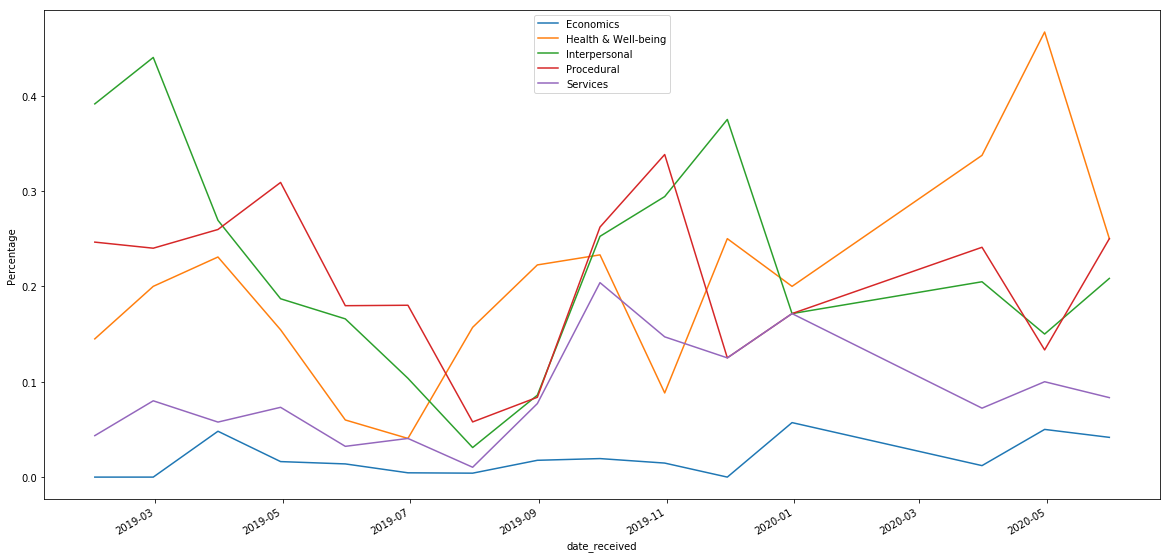

In [11]:
# Categories over time, since 2019, normalized, excluding Operations
fig, ax = plt.subplots()
ax.set_ylabel('Percentage')
for key, data in df_cat[df_cat['name'] != 'Operations'].groupby('name'):
    data.plot(x='date_received', y='percentage', ax=ax, label=key, figsize=(20,10))

In [12]:
# Flatten subtags
df_flat = pd.DataFrame([[i, x] for i, y in df['subtags'].apply(list).iteritems() for x in y],
                       columns=['I', 'subtags'])
df_flat = df_flat.set_index('I')
df_iss = df.drop('subtags', 1).merge(df_flat, left_index=True, right_index=True)


# Format for issues chart
df_iss.index = df_iss['date_received']
df_iss = (df_iss.groupby([pd.Grouper(freq='M'), 'subtags', 'name'])
                .count()
                .filter(['subtags', 'eid'])
                .rename(columns={'eid': 'count'})
                .reset_index()
         )
df_iss['subtags'] = list(zip(df_iss['subtags'], df_iss['name']))

# Pad zeroes
n_months = df_iss['date_received'].unique()
n_issues = df_iss['subtags'].unique()
n_idx = pd.MultiIndex.from_product((n_months, n_issues), names=['date_received', 'subtags'])
df_iss = df_iss.set_index(['date_received', 'subtags']).reindex(n_idx, fill_value=0).reset_index()

# Normalize
df_iss_sum = df_iss.groupby('date_received').sum()
df_iss_sum.columns = ['sum']
df_iss = df_iss.join(df_iss_sum, on='date_received')
df_iss['percentage'] = df_iss['count'] / df_iss['sum']

# Remove months with less than 5 entries
df_iss = df_iss[df_iss['sum'] >= 5]

# Reformat
df_iss[['subtags', 'name']] = pd.DataFrame(df_iss['subtags'].tolist(), index=df_iss.index)

,date_received,subtags,name,count,sum,percentage
0,2019-01-31 00:00:00+00:00,Air quality,Services,1,69,0.014493
1,2019-01-31 00:00:00+00:00,Classification,Procedural,1,69,0.014493
2,2019-01-31 00:00:00+00:00,Grievance,Procedural,1,69,0.014493
3,2019-01-31 00:00:00+00:00,Harassment,Interpersonal,1,69,0.014493
4,2019-01-31 00:00:00+00:00,Medical,Health & Well-being,10,69,0.144928
5,2019-01-31 00:00:00+00:00,PREA,Interpersonal,5,69,0.072464
6,2019-01-31 00:00:00+00:00,Parole,Procedural,15,69,0.217391
7,2019-01-31 00:00:00+00:00,Request for CA report,Operations,2,69,0.028986
8,2019-01-31 00:00:00+00:00,Request for further correspondence,Operations,3,69,0.043478
9,2019-01-31 00:00:00+00:00,Request for interview,Operations,1,69,0.014493


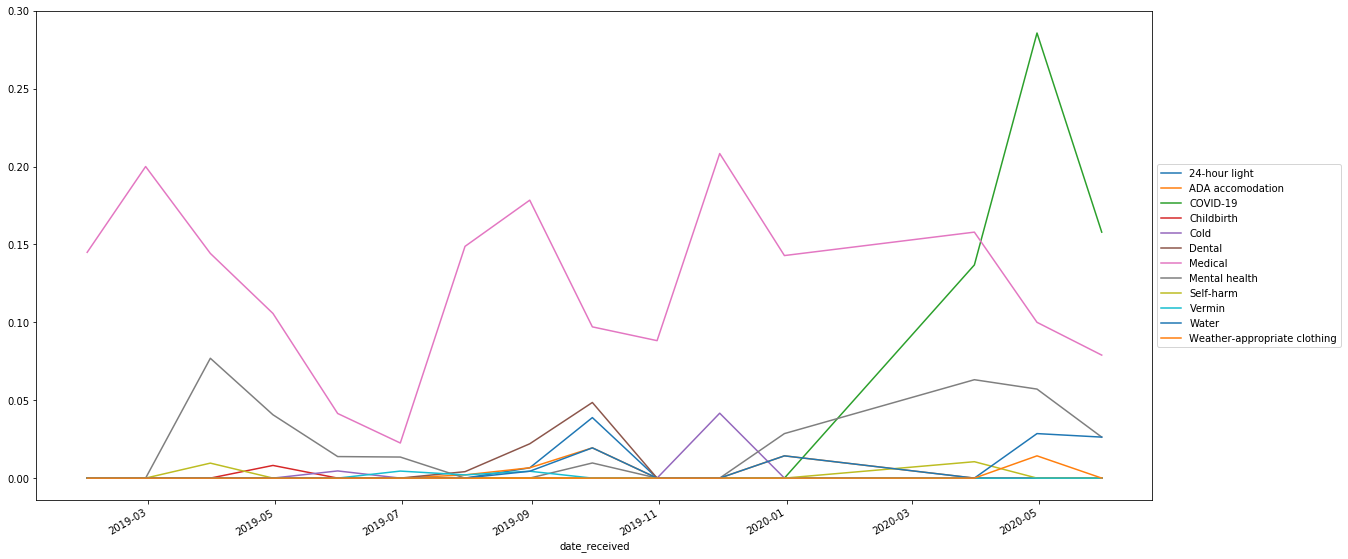

In [13]:
# Health & Well-being issues over time, since 2019
fig, ax = plt.subplots()

for key, data in df_iss[df_iss['name'] == 'Health & Well-being'].groupby('subtags'):
    data.plot(x='date_received', y='percentage', ax=ax, label=key, figsize=(20,10))
    
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

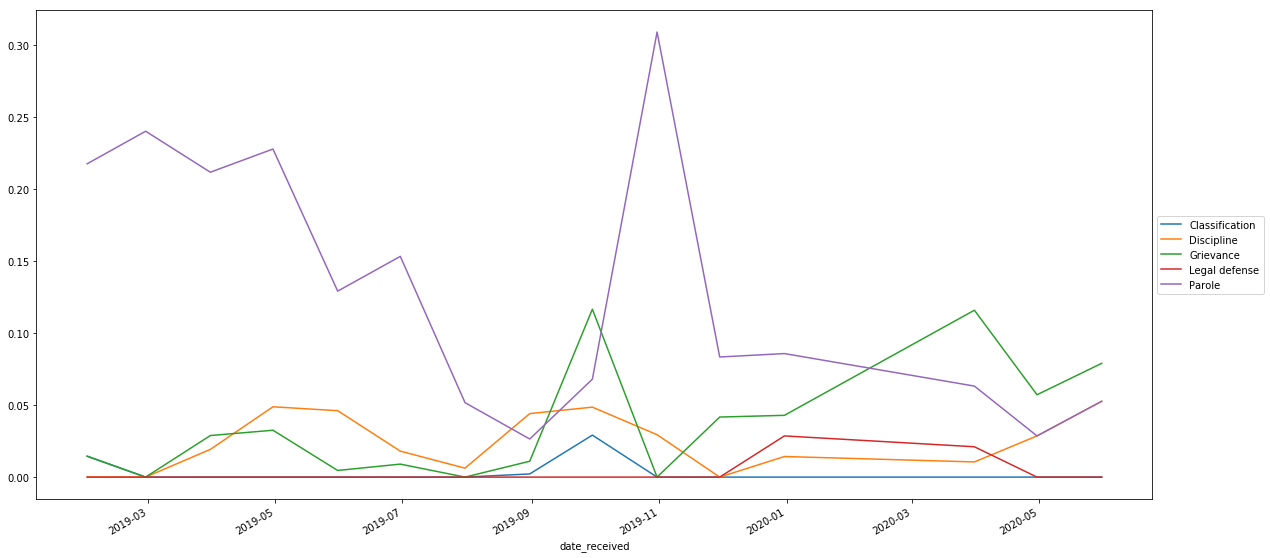

In [14]:
# Procedural issues over time, since 2019
fig, ax = plt.subplots()
for key, data in df_iss[df_iss['name'] == 'Procedural'].groupby('subtags'):
    data.plot(x='date_received', y='percentage', ax=ax, label=key, figsize=(20,10))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

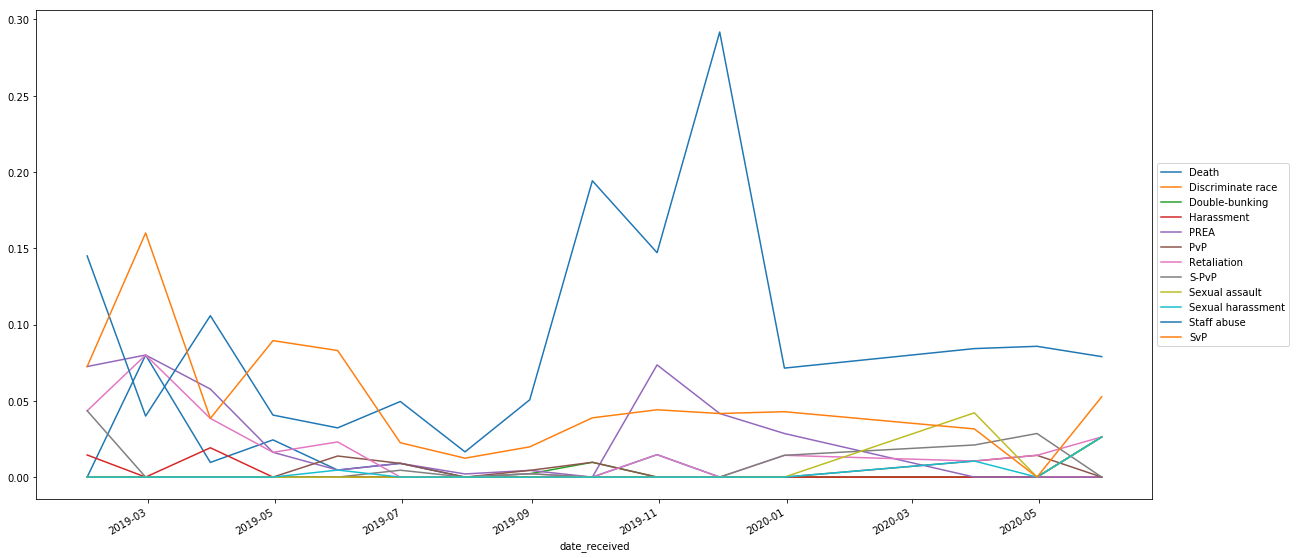

In [15]:
# Interpersonal issues over time, since 2019
fig, ax = plt.subplots()
for key, data in df_iss[df_iss['name'] == 'Interpersonal'].groupby('subtags'):
    data.plot(x='date_received', y='percentage', ax=ax, label=key, figsize=(20,10))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

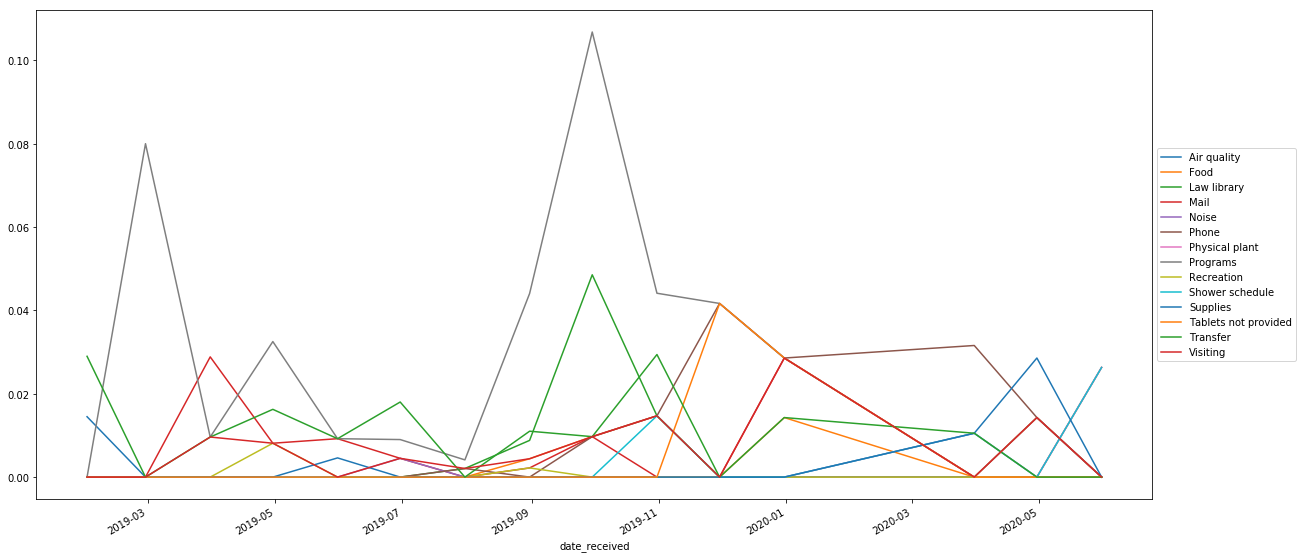

In [16]:
# Services issues over time, since 2019
fig, ax = plt.subplots()
for key, data in df_iss[df_iss['name'] == 'Services'].groupby('subtags'):
    data.plot(x='date_received', y='percentage', ax=ax, label=key, figsize=(20,10))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))